# Import RFM data

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import squarify
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')


In [6]:
df_RFM = pd.read_csv('df_RFM.csv')
df_RFM.head()

,Member_number,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
0,2193,91,21,361.45,3,4,4,344,11
1,1793,26,19,345.10,4,4,4,444,12
2,3289,4,21,334.15,4,4,4,444,12
3,2433,3,24,316.81,4,4,4,444,12
4,2743,142,15,312.46,2,4,4,244,10


# Manual Segmentation

In [7]:
def rfm_level(df):
    # Check for special 'STARS' and 'NEW' conditions first
    if df['RFM_Score'] == 12:
        return 'STARS'
    elif df['R'] == 4 and df['F'] == 1 and df['M'] == 1:
        return 'NEW'
    # Then check for other conditions
    elif df['M'] == 4:
        return 'BIG SPENDER'
    elif df['F'] == 4:
        return 'LOYAL'
    elif df['R'] == 4:
        return 'ACTIVE'
    elif df['R'] == 1:
        return 'LOST'
    elif df['M'] == 1:
        return 'LIGHT'
    else:
        return 'REGULARS'

In [8]:
# Create a new column RFM_Level
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis=1)
df_RFM.head()

,Member_number,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
0,2193,91,21,361.45,3,4,4,344,11,BIG SPENDER
1,1793,26,19,345.10,4,4,4,444,12,STARS
2,3289,4,21,334.15,4,4,4,444,12,STARS
3,2433,3,24,316.81,4,4,4,444,12,STARS
4,2743,142,15,312.46,2,4,4,244,10,BIG SPENDER


In [9]:
df_RFM['RFM_Level'].value_counts()

RFM_Level
REGULARS       875
LOST           875
BIG SPENDER    689
ACTIVE         414
LIGHT          388
LOYAL          301
STARS          286
NEW             70
Name: count, dtype: int64

In [11]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg = df_RFM.groupby('RFM_Level').agg({
    'Recency': 'median',
    'Frequency': 'median',
    'Monetary': ['median', 'count']}).round(0)

rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)

# Reset the index
rfm_agg = rfm_agg.reset_index()
rfm_agg

,RFM_Level,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,ACTIVE,30.0,8.0,71.0,414,10.62
1,BIG SPENDER,128.0,13.0,146.0,689,17.68
2,LIGHT,157.0,5.0,29.0,388,9.95
3,LOST,399.0,5.0,41.0,875,22.45
4,LOYAL,85.0,13.0,96.0,301,7.72
5,NEW,16.0,4.0,23.0,70,1.80
6,REGULARS,145.0,8.0,71.0,875,22.45
7,STARS,30.0,15.0,161.0,286,7.34


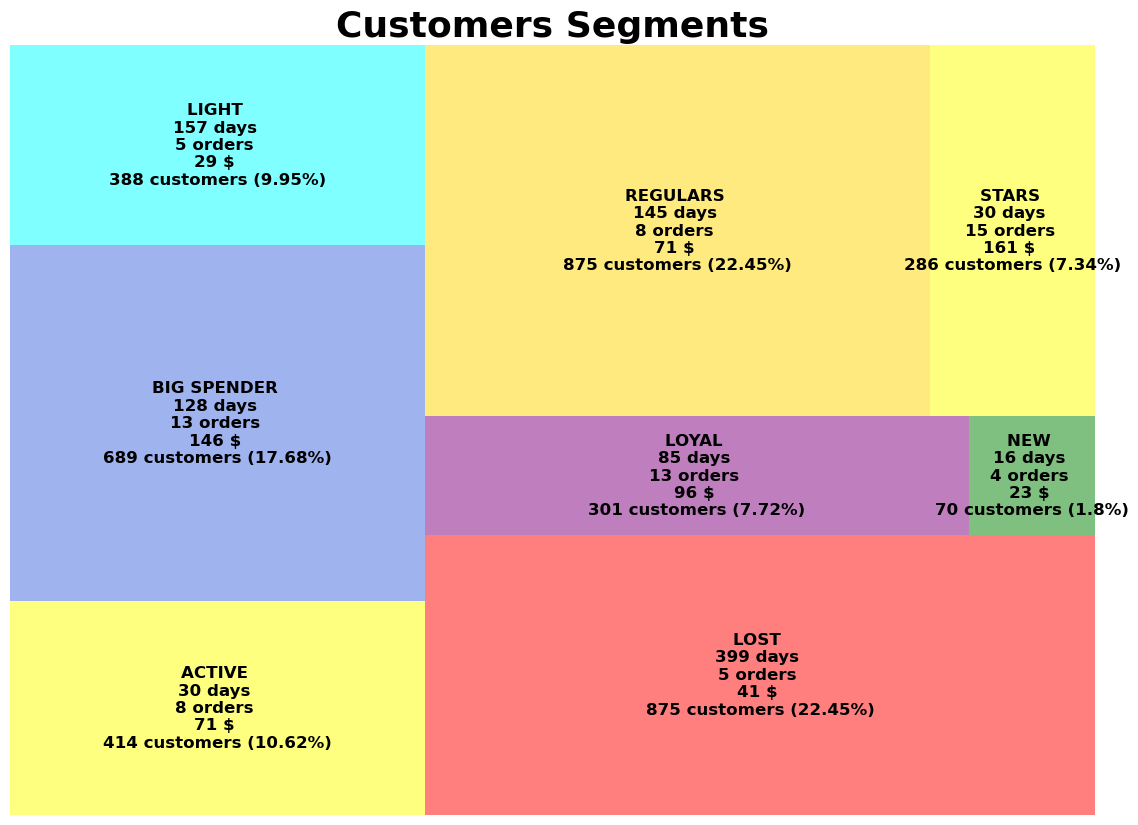

In [12]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict = {'ACTIVE':'yellow','BIG SPENDER':'royalblue', 'LIGHT':'cyan',
               'LOST':'red', 'LOYAL':'purple', 'NEW':'green', 'STARS':'gold'}

squarify.plot(sizes=rfm_agg['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
                      for i in range(0, len(rfm_agg))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('RFM Segments.png')
plt.show()

In [13]:
import plotly.express as px

fig = px.scatter(rfm_agg, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="RFM_Level",
           hover_name="RFM_Level", size_max = 60) 
fig.show()

# KMeans
## Kmeans clusters with the Elbow Method

In [5]:
df = df_RFM[['Recency','Frequency','Monetary']]
df.head()

,Recency,Frequency,Monetary
0,91,21,361.45
1,26,19,345.10
2,4,21,334.15
3,3,24,316.81
4,142,15,312.46


In [120]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

sse

{1: 111667978.71493208,
 2: 39455852.3022563,
 3: 24266830.718370393,
 4: 19323283.695120882,
 5: 13796961.205798203,
 6: 12166656.581596589,
 7: 9912813.781841293,
 8: 8529392.524660083,
 9: 7611418.888219991,
 10: 6804636.462250587,
 11: 6190529.485145832,
 12: 5775860.457698934,
 13: 5327407.671476472,
 14: 4964269.929508292,
 15: 4651268.745433607,
 16: 4340818.100010535,
 17: 4024789.5150646623,
 18: 3875848.044465368,
 19: 3676281.7155400217}

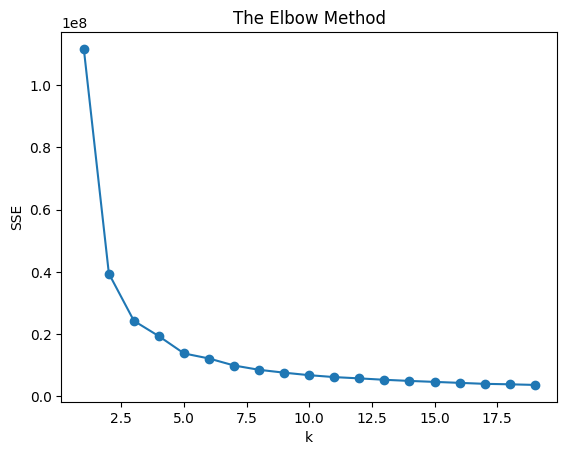

In [121]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')

plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.show()

In [122]:
# Build model with k=5
model = KMeans(n_clusters=5, random_state=42)
model.fit(df)
model.labels_.shape

(3898,)

In [123]:
df["Cluster"] = model.labels_
df.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0        191.81      8.61    78.36  1076
1        560.38      4.27    37.16   300
2         63.63     14.83   175.41   603
3         55.30      8.69    71.32  1204
4        352.74      6.73    61.28   715

In [124]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg2 = df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2['Percent'] = round((rfm_agg2['Count']/rfm_agg2.Count.sum())*100, 2)

# Reset the index
rfm_agg2 = rfm_agg2.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg2['Cluster'] = 'Cluster '+ rfm_agg2['Cluster'].astype('str')

# Print the aggregated dataset
rfm_agg2

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,Cluster 0,192.0,9.0,78.0,1076,27.60
1,Cluster 1,560.0,4.0,37.0,300,7.70
2,Cluster 2,64.0,15.0,175.0,603,15.47
3,Cluster 3,55.0,9.0,71.0,1204,30.89
4,Cluster 4,353.0,7.0,61.0,715,18.34


Kết quả phân cụm có 5 cụm như sau:

| Cụm | Số lượng | Đặc trưng tiềm năng |
|-----|----------|----------------------|
| 0   | 1076     | Phân khúc khách hàng chiếm tỷ lệ khá lớn (27.60%), có tần suất giao dịch trung bình (9.0), chi tiêu hoặc giá trị giao dịch trung bình (78.0), nhưng thời gian gần đây không hoạt động nhiều (192 ngày). Có thể là nhóm khách hàng trung thành nhưng không thường xuyên. |
| 1   | 300      | Phân khúc nhỏ nhất (7.70%), tần suất giao dịch thấp (4.0), chi tiêu hoặc giá trị giao dịch thấp (37.0), và đã lâu không hoạt động (560 ngày). Có thể là nhóm khách hàng không tích cực hoặc đã rời bỏ. |
| 2   | 603      | Phân khúc khách hàng trung bình (15.47%), tần suất giao dịch cao (15.0), chi tiêu hoặc giá trị giao dịch cao nhất (175.0), và hoạt động gần đây (64 ngày). Có thể là nhóm khách hàng cao cấp, thường xuyên và giá trị lớn. |
| 3   | 1204     | Phân khúc lớn nhất (30.89%), tần suất giao dịch trung bình (9.0), chi tiêu hoặc giá trị giao dịch trung bình (71.0), và hoạt động rất gần đây (55 ngày). Có thể là nhóm khách hàng phổ biến, ổn định và đang tích cực. |
| 4   | 715      | Phân khúc trung bình (18.34%), tần suất giao dịch trung bình (7.0), chi tiêu hoặc giá trị giao dịch trung bình (61.0), nhưng không hoạt động gần đây (353 ngày). Có thể là nhóm khách hàng tiềm năng nhưng đang giảm dần sự gắn kết. |

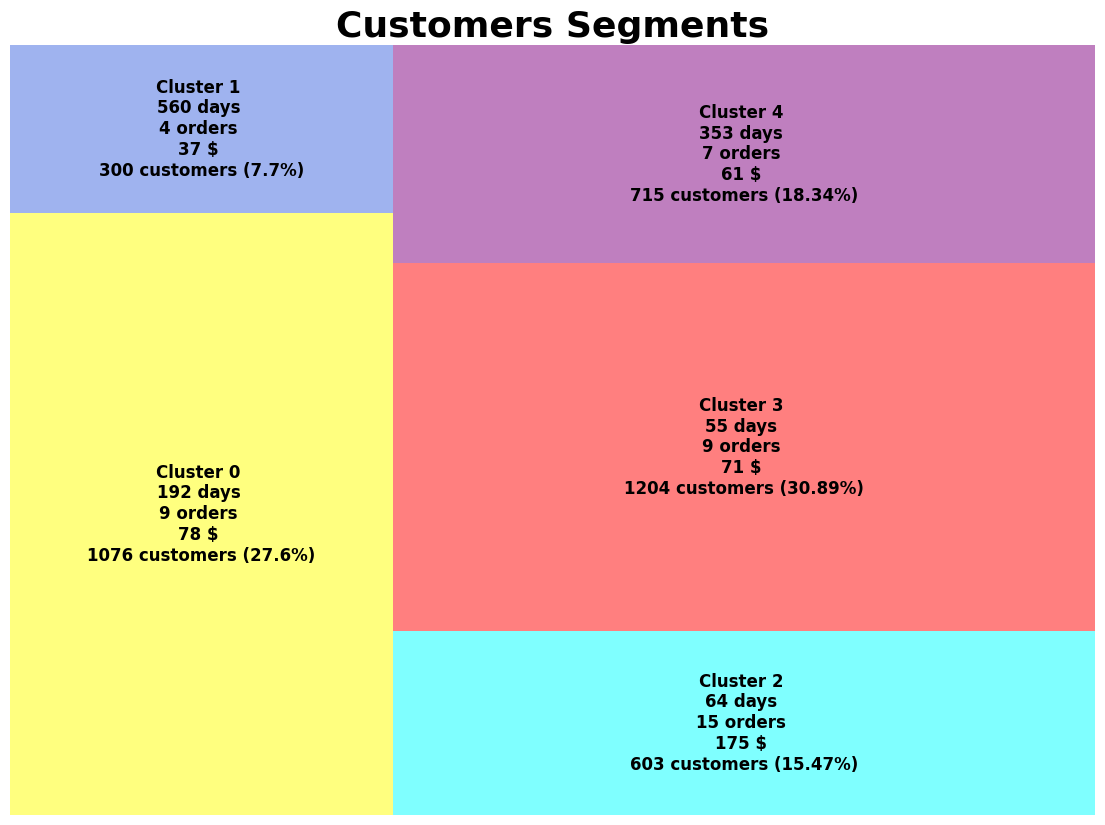

In [125]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=rfm_agg2['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2.iloc[i])
                      for i in range(0, len(rfm_agg2))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('Kmeans Unsupervised Segments.png')
plt.show()

In [126]:
import plotly.express as px

fig = px.scatter(rfm_agg2, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100)
fig.show()

# Hierarchical Clustering

In [15]:
df_RFM = df_RFM[['Member_number', 'Recency', 'Frequency', 'Monetary']]
df_RFM.head()

,Member_number,Recency,Frequency,Monetary
0,2193,91,21,361.45
1,1793,26,19,345.10
2,3289,4,21,334.15
3,2433,3,24,316.81
4,2743,142,15,312.46


## Remove Outliers

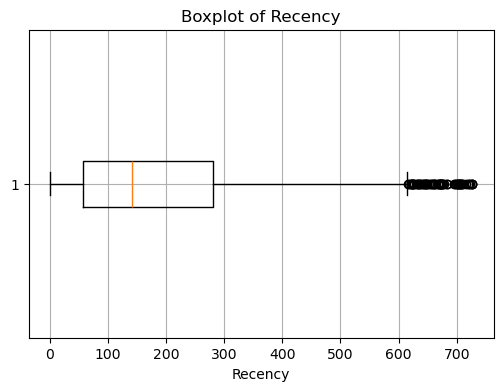

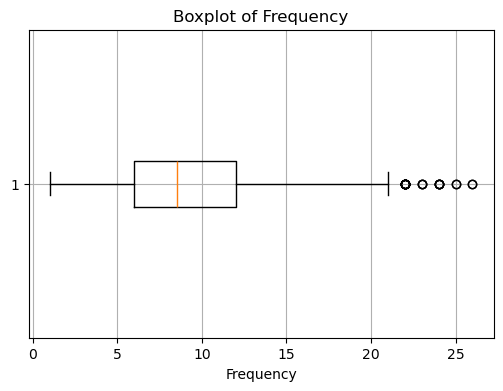

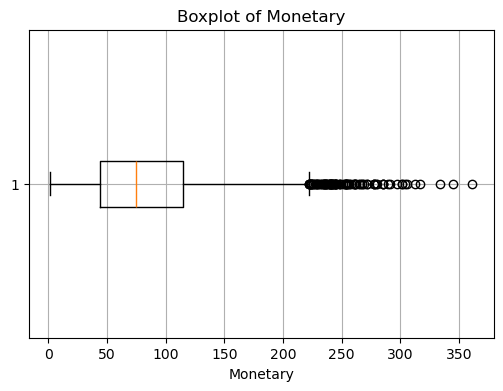

In [17]:
def plot_box(df, col):
    plt.figure(figsize=(6, 4))
    plt.boxplot(df[col], vert=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.grid(True)
    plt.show()
    
plot_box(df_RFM, 'Recency')
plot_box(df_RFM, 'Frequency')
plot_box(df_RFM, 'Monetary')



In [18]:
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered_df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return filtered_df

df_clean = remove_outliers_iqr(df_RFM, 'Recency')
df_clean = remove_outliers_iqr(df_RFM, 'Frequency')
df_clean = remove_outliers_iqr(df_RFM, 'Recency')


In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df_clean[['Recency', 'Frequency', 'Monetary']]
scaled_df = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
scaled_df.describe()

,Recency,Frequency,Monetary
count,3.830000e+03,3830.000000,3830.000000
mean,2.968325e-17,0.000000,0.000000
std,1.000131e+00,1.000131,1.000131
min,-1.212851e+00,-1.837323,-1.536019
25%,-8.337569e-01,-0.692210,-0.745692
50%,-2.786554e-01,-0.005143,-0.186813
75%,6.267692e-01,0.681925,0.543162
max,2.943641e+00,3.888241,4.989973


## Plot the dendrogram

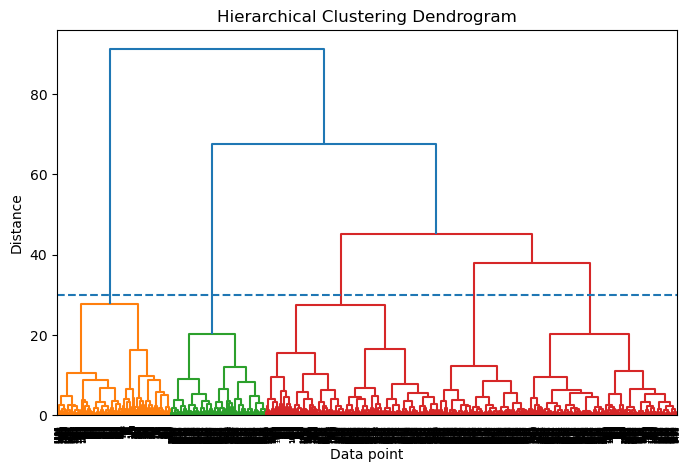

In [22]:
Z = linkage(scaled_df, method='ward')
# Plot the dendrogram
plt.figure(figsize=(8, 5))
dendrogram(Z, labels=scaled_df.index.tolist())  # Use labels from DataFrame index
plt.title('Hierarchical Clustering Dendrogram')
plt.axhline(30, linestyle='--')
plt.xlabel('Data point')
plt.ylabel('Distance')
plt.show()

## Clustering

In [33]:
from scipy.cluster.hierarchy import fcluster

# Cắt thành 6 cụm 
cluster_labels = fcluster(Z, 8, criterion='maxclust')

# Thêm vào DataFrame để dễ xem
scaled_df['Cluster'] = cluster_labels
scaled_df.columns = ['Recency_scaled','Frequency_scaled', 'Monetary_scaled', 'Cluster' ]

scaled_df.head()


,Recency_scaled,Frequency_scaled,Monetary_scaled,Cluster
0,-0.596823,2.743128,4.989973,2
1,-1.036843,2.285083,4.693873,2
2,-1.185772,2.743128,4.495566,2
3,-1.192542,3.430196,4.181536,2
4,-0.251577,1.368993,4.102757,2


In [34]:
scaled_df.groupby('Cluster')['Recency_scaled'].count()

Cluster
1    408
2    296
3    265
4    323
5    484
6    584
7    547
8    923
Name: Recency_scaled, dtype: int64

In [35]:
df = pd.concat([df_RFM, scaled_df],axis=1)
df.head()

,Member_number,Recency,Frequency,Monetary,Recency_scaled,Frequency_scaled,Monetary_scaled,Cluster
0,2193,91,21,361.45,-0.596823,2.743128,4.989973,2.0
1,1793,26,19,345.10,-1.036843,2.285083,4.693873,2.0
2,3289,4,21,334.15,-1.185772,2.743128,4.495566,2.0
3,2433,3,24,316.81,-1.192542,3.430196,4.181536,2.0
4,2743,142,15,312.46,-0.251577,1.368993,4.102757,2.0


In [36]:
mean_values = df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

#calculate Count
count_values = df.groupby('Cluster')['Monetary'].count()

rfm_agg = mean_values.round(0)
rfm_agg['Monetary_count'] = count_values
rfm_agg.columns = ['RecencyMean', 'FrequencyMean', 'MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)


rfm_agg = rfm_agg.reset_index()
rfm_agg

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,1.0,90.0,14.0,132.0,408,10.65
1,2.0,99.0,16.0,212.0,296,7.73
2,3.0,265.0,5.0,33.0,265,6.92
3,4.0,273.0,5.0,38.0,323,8.43
4,5.0,192.0,10.0,111.0,484,12.64
5,6.0,181.0,8.0,68.0,584,15.25
6,7.0,256.0,5.0,36.0,547,14.28
7,8.0,158.0,9.0,86.0,923,24.10


In [30]:
# name for each cluster
cluster_names = {
    1.0: "Mid-Spenders",
    2.0: "High-Spenders",
    3.0: "Lost Low-Value",
    4.0: "At-Risk Moderate",
    5.0: "Lost Low-Value",
    6.0: "Potential to Reactivate"
}

rfm_agg['Segment'] = rfm_agg['Cluster'].map(cluster_names)
rfm_agg

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent,Segment
0,1.0,90.0,14.0,132.0,408,10.65,Loyal Mid-Spenders
1,2.0,99.0,16.0,212.0,296,7.73,Loyal High-Spenders
2,3.0,270.0,5.0,36.0,588,15.35,Lost Low-Value
3,4.0,186.0,9.0,87.0,1068,27.89,At-Risk Moderate
4,5.0,256.0,5.0,36.0,547,14.28,Lost Low-Value
5,6.0,158.0,9.0,86.0,923,24.10,Potential to Reactivate


In [ ]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict = {'ACTIVE':'yellow','BIG SPENDER':'royalblue', 'LIGHT':'cyan',
               'LOST':'red', 'LOYAL':'purple', 'NEW':'green', 'STARS':'gold'}

squarify.plot(sizes=rfm_agg['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
                      for i in range(0, len(rfm_agg))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('RFM Segments.png')
plt.show()

In [29]:
import plotly.express as px

fig = px.scatter(rfm_agg, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max = 60) 
fig.show()